In [1]:
%run ../code/Limpeza.ipynb

In [2]:
%run ../code/Representacao.ipynb

In [3]:
%run ../code/Clusterizacao.ipynb

In [4]:
#-------BASE-------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
#-------CHEM-------#
from rdkit import RDLogger
import cirpy
#-------MACHINE LEARNING-------#
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [5]:
# Desabilita os warnings do RDKit
RDLogger.DisableLog('rdApp.*')

***

In [6]:
def ANN(fpSize: int):
    
    # Define o modelo ANN
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='relu', input_shape=(fpSize,)),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

***

# MOUSE, ORAL

In [7]:
use_count = True
fpSize = 8192
radius = 3

In [8]:
# Obtem os dados
mouse_vo = pd.read_csv('../dados/mouse_vo.csv', usecols=['mouse_vo', 'smiles'])

# Converter valores da coluna 'valor' para float
mouse_vo['mouse_vo'] = pd.to_numeric(mouse_vo['mouse_vo'], errors='coerce')

# Remove NaN
mouse_vo.dropna(subset=['mouse_vo', 'smiles'], inplace=True, ignore_index=True)

# Normaliza LD50
mouse_vo['log_ld50'] = -np.log(mouse_vo['mouse_vo'])

# Realiza a limpeza dos dados
limpeza = Limpeza(dataframe=mouse_vo)
mouse_vo = limpeza.dados_limpos(col_smiles='smiles', col_valor='mouse_vo', sanitize=True, cutoff=.05, fragmento=False)

# Define a representação fingerprint
representacao = Representacao(dataframe=mouse_vo)
mouse_vo = representacao.fingerprint(col_smiles='smiles', fingerprint='morgan', use_count=use_count, fpSize=fpSize, radius=radius)

# Define os conjuntos de treinamento e teste
X = np.array(mouse_vo['Features'].to_list())
y = mouse_vo['log_ld50'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplica ANN
model = ANN(fpSize=fpSize)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

history = model.fit(X_train, y_train, validation_split=0.1, epochs=200, batch_size=32)

C:\Users\berna\anaconda3\envs\saedc_ml\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 300)            │     2,457,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,488,101 (9.49 MB)

 Trainable params: 2,488,101 (9.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 7.5507 - mae: 1.9044 - val_loss: 2.2376 - val_mae: 1.0441
Epoch 2/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 1.2735 - mae: 0.7984 - val_loss: 1.8760 - val_mae: 0.9766
Epoch 3/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.7511 - mae: 0.6223 - val_loss: 1.7612 - val_mae: 0.9310
Epoch 4/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.5936 - mae: 0.5411 - val_loss: 1.6637 - val_mae: 0.8878
Epoch 5/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.4769 - mae: 0.4707 - val_loss: 1.7006 - val_mae: 0.9028
Epoch 6/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.5277 - mae: 0.4574 - val_loss: 1.8440 - val_mae: 0.9309
Epoch 7/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.3498 - mae: 0.4053 - val_loss: 1.6517 - val_mae: 0.8904
Epoch 8/200
604/604 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - loss: 0.2749 - mae: 0.3540 - val_loss: 1.5924 - val_mae: 0.8726
Epoch 9/200
604/604 ━━━━━━━━━━━━

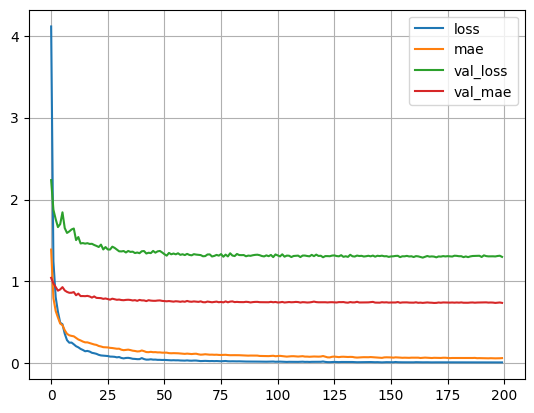

In [9]:
# History
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.show()

In [10]:
# Obtem as métricas do modelo
loss, mae = model.evaluate(X_test, y_test)

# R-squared
predictions = model.predict(X_test)
y_true = np.array(y_test)
y_pred = np.array(predictions)

r2 = r2_score(y_true, y_pred)

print(f'loss: {loss}')
print(f'mae: {mae}')
print(f'r2: {r2}')

168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1913 - mae: 0.7197
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
loss: 1.1566836833953857
mae: 0.7190252542495728
r2: 0.4142982269075216


***

# Validação

In [11]:
def ld50(log_ld50):
    return float(np.exp(-log_ld50))

def ghs_category(ld_50):
    if ld_50 <= 5:
        return 1
    elif ld_50 > 5 and ld_50 <= 50:
        return 2
    elif ld_50 > 50 and ld_50 <= 300:
        return 3
    elif ld_50 > 300 and ld_50 <= 2000:
        return 4
    elif ld_50 >= 2000:
        return 5
    else:
        return None

def classe_eh_a_mesma(ghs_observada, ghs_predita):
    return ghs_observada == ghs_predita

def reduz_animais(ghs_observada, ghs_predita):
    if ghs_observada > 3 and ghs_observada > ghs_predita:
        return True
    elif ghs_observada < 3 and ghs_observada < ghs_predita:
        return True
    elif ghs_observada == ghs_predita and ghs_observada != 3:
        return True
    elif ghs_predita == 3:
        return False
    else:
        return False

In [12]:
ghs = pd.DataFrame({
    'observado':y_true,
    'predito': [pred[0] for pred in y_pred]
})

***

# ATC method

In [13]:
ghs['ld50_observado'] = ghs['observado'].apply(ld50)
ghs['ld50_predito'] = ghs['predito'].apply(ld50)

In [14]:
ghs['ghs_observada'] = ghs['ld50_observado'].apply(ghs_category)
ghs['ghs_predita'] = ghs['ld50_predito'].apply(ghs_category)

In [15]:
ghs['mesma_classe'] = ghs.apply(lambda row: classe_eh_a_mesma(row['ghs_observada'], row['ghs_predita']), axis=1)

In [16]:
ghs['reduz_animais'] = ghs.apply(lambda row: reduz_animais(row['ghs_observada'], row['ghs_predita']), axis=1)

In [17]:
print(f'Predição da classe correta: {(ghs['mesma_classe'].sum() * 100) / ghs.shape[0]}')
print(f'Redução de animais: {(ghs['reduz_animais'].sum() * 100) / ghs.shape[0]}')

Predição da classe correta: 67.4310216256525
Redução de animais: 77.51677852348993


In [18]:
ghs.to_excel('validacao_mouse_vo.xlsx', index=False)